In [12]:
from google.colab import drive
drive.mount('/content/drive')

import sys

if "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES" not in sys.path:
  sys.path.append("/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES")


BASE_PATH = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/"

dataset_train_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/data/datasets/huffpost-news/news-article-categories.csv"
model_path = "/content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
train_df=pd.read_csv(dataset_train_path)
train_df.head()

,category,title,body
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis..."
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, a 26-year-old who lives in Huds..."
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,There’s something about combining the traditio...


In [14]:
train_df['category'].value_counts()

ARTS & CULTURE    1002
BUSINESS           501
ENTERTAINMENT      501
ENVIRONMENT        501
POLITICS           501
RELIGION           501
SPORTS             501
TECH               501
WOMEN              501
EDUCATION          490
COMEDY             380
SCIENCE            350
MEDIA              347
CRIME              300
Name: category, dtype: int64

In [15]:
train_df['encoded_cat'] = train_df['category'].astype('category').cat.codes
train_df

,category,title,body,encoded_cat
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,"In October 2017, Carolyn Kramer received a dis...",0
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,This week I talked with actor Jeff Hiller abou...,0
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,The New Yorker is taking on President Donald T...,0
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, a 26-year-old who lives in Huds...",0
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,There’s something about combining the traditio...,0
...,...,...,...,...
6872,WOMEN,Casually Fearless: Why Millennials Are Natural...,I still think about that Tuesday night dinner ...,13
6873,WOMEN,Happy Birthday To Us,I remember the morning of my high school gradu...,13
6874,WOMEN,The Culture of Love,"My husband, Gene, doesn't wear pajamas. I aske...",13
6875,WOMEN,"Carpe Diem, Oprah Style","\nBy AntonioGuillem, via ThinkStock\nBy Lisa ...",13


In [16]:
# dropping None strings
train_df = train_df.dropna()

In [17]:
X=list(train_df['body'])
y=list(train_df['encoded_cat'])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42,stratify=y)

In [19]:
!pip install transformers;
!pip install torch;

In [29]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', num_labels=14)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [30]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [31]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [32]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir=BASE_PATH + "/models/huffpost-model",          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    logging_steps=5,
    eval_steps=100,
    disable_tqdm=False
)

In [33]:
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=14)

trainer = TFTrainer(
    model=trainer_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)


trainer.train()

# save the model
trainer.save_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [34]:
from sklearn.metrics import classification_report
target_names = ['ARTS AND CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'MEDIA', 'POLITICS', 'RELIGION', 'SCIENCE', 'SPORTS', 'TECH', 'WOMEN']
print(classification_report(
    y_test,
    trainer.predict(test_dataset)[1],
    target_names=target_names
    )
)

                  precision    recall  f1-score   support

ARTS AND CULTURE       1.00      1.00      1.00       201
        BUSINESS       1.00      1.00      1.00       100
          COMEDY       1.00      1.00      1.00        75
           CRIME       1.00      1.00      1.00        60
       EDUCATION       1.00      1.00      1.00        98
   ENTERTAINMENT       1.00      1.00      1.00       100
     ENVIRONMENT       1.00      1.00      1.00       100
           MEDIA       1.00      1.00      1.00        70
        POLITICS       1.00      1.00      1.00       100
        RELIGION       1.00      1.00      1.00       100
         SCIENCE       1.00      1.00      1.00        70
          SPORTS       1.00      1.00      1.00       100
            TECH       1.00      1.00      1.00       101
           WOMEN       1.00      1.00      1.00       100

        accuracy                           1.00      1375
       macro avg       1.00      1.00      1.00      1375
    weighted

In [92]:
import numpy as np
import matplotlib.pyplot as plt

target_names = ['ARTS AND CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'MEDIA', 'POLITICS', 'RELIGION', 'SCIENCE', 'SPORTS', 'TECH', 'WOMEN']

def radar_chart(categories, values_array, title='Radar Chart'):
    # Number of categories
    num_categories = len(categories)

    # Calculate angle for each category
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

    values_copy = []
    # Make the plot circular
    for i in range(len(values_array)):
        values_copy.append(values_array[i] + values_array[i][:1])
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for i in range(len(values_array)):
        ax.fill(angles, values_copy[i], alpha=0.25)

    # Set the y-axis limit to 1
    ax.set_ylim(-0.1, 1)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)  # Adjust font size

    # Add a title
    plt.title(title, size=14, color='blue', y=1.1)  # Adjust title font size

    # Show the plot
    plt.show()


Some layers from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_239']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model and are newly initialized: ['dropout_539']
You should probably TRAIN this model on a down-stream

[0.006578412838280201, 0.0034043483901768923, 0.004459908697754145, 0.00583779439330101, 0.005493436008691788, 0.011688991449773312, 0.0037276307120919228, 0.005666954442858696, 0.003570553148165345, 0.002580470172688365, 0.0024738183710724115, 0.9343696236610413, 0.0031465503852814436, 0.007001419086009264]


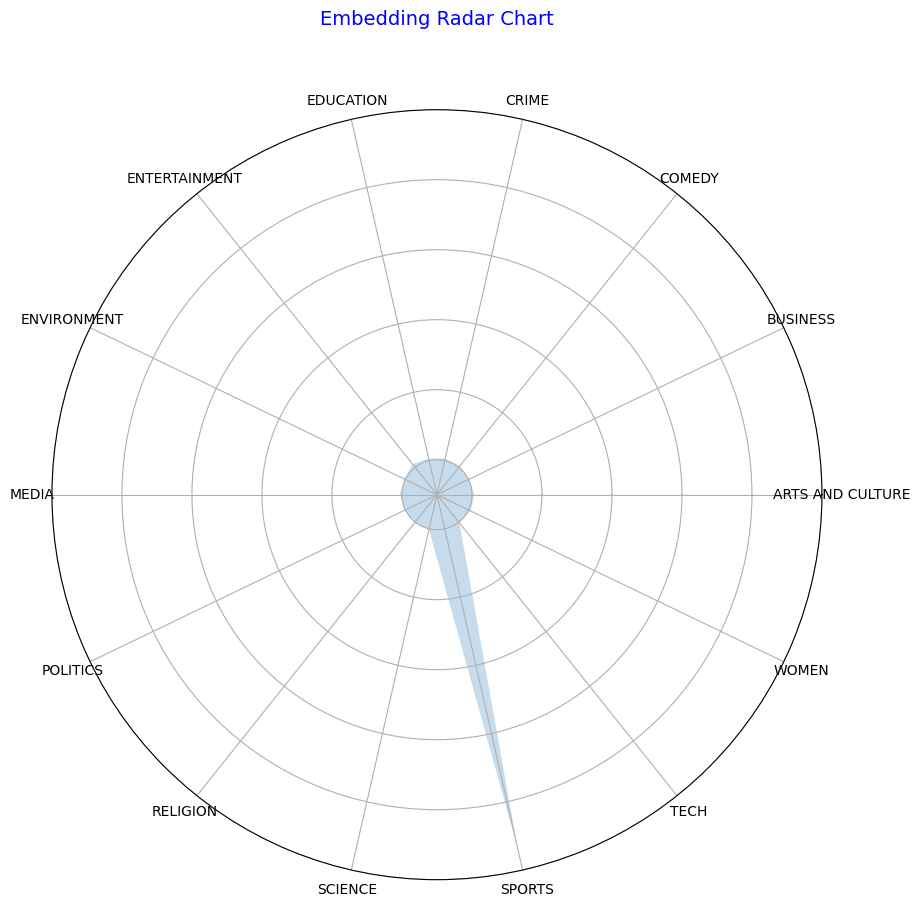

In [93]:
from transformers import TextClassificationPipeline, DistilBertTokenizerFast, TFDistilBertForSequenceClassification

tokenizer_inference = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trainer_model_inference = TFDistilBertForSequenceClassification.from_pretrained(model_path)

input_text = """
              The world’s most popular sport is played by millions around the world, making it easily accessible to young talent.

A number of teenagers have excelled at an early age, but Littler’s achievements have drawn comparisons with one particular English phenom’s arrival on the global stage.

Wayne Rooney was also just 16 when he made his senior debut for Everton and, like Littler, looked wise beyond his years.

Later that same season, still just 16, the English striker scored a stunning goal against Arsenal to truly announce himself to the world.

It was a moment of pure audaciousness, a long-range effort which flashed past David Seaman in goal. After witnessing Rooney’s performance live, then Arsenal manager Arsene Wenger hailed the youngster as the “biggest English talent” he’d ever seen, adding that he hoped the teenager could deal with the attention.
              """

pipe = TextClassificationPipeline(model=trainer_model_inference, tokenizer=tokenizer_inference, return_all_scores=True)

#trainer.predict(input_embeddings)

res=pipe(input_text)

scores = []
for row in res[0]:
  scores.append(row["score"])

print(scores)

# Example usage
categories = target_names
values = scores

radar_chart(categories, [values], title='Embedding Radar Chart')

Some layers from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_239']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/INDUSTRIAL_APPLICATIONS_TRAVEL_TALES/models/huffpost-model and are newly initialized: ['dropout_559']
You should probably TRAIN this model on a down-stream

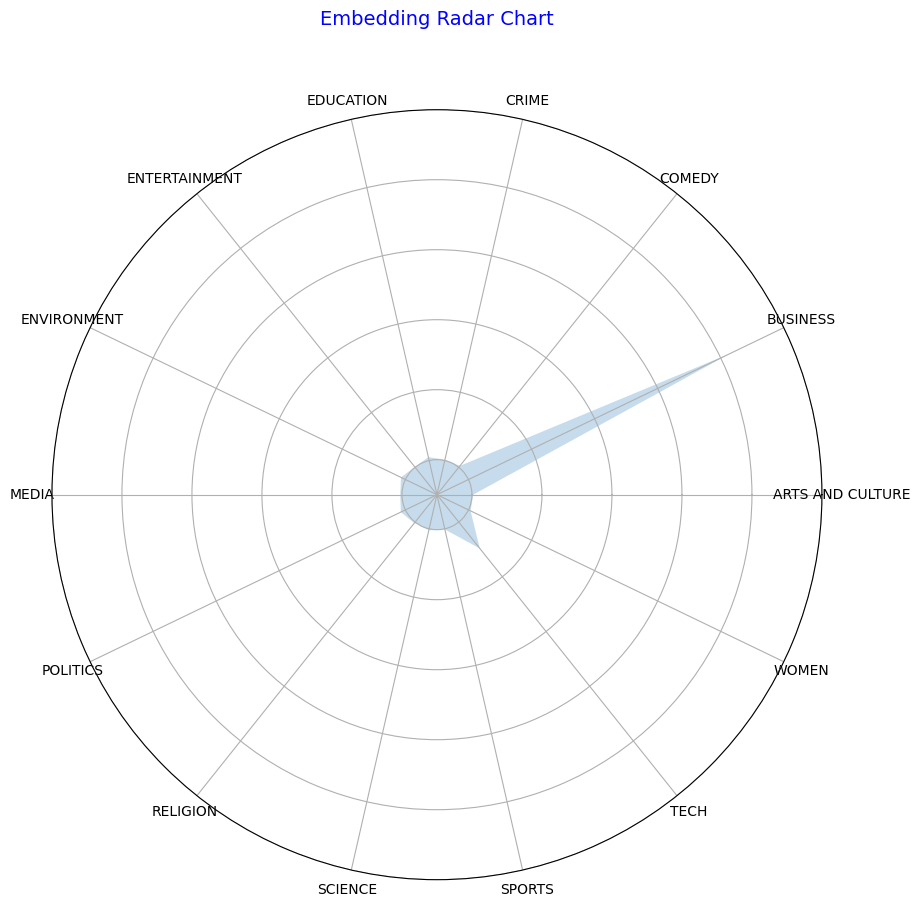

In [94]:
from transformers import TextClassificationPipeline, DistilBertTokenizerFast, TFDistilBertForSequenceClassification

tokenizer_inference = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trainer_model_inference = TFDistilBertForSequenceClassification.from_pretrained(model_path)

input_text = """
Shein, a Chinese fast-fashion retailer, is being grilled by U.S. regulators about its relationship with China and its data protections. The company is preparing for an IPO in the United States.
"""

pipe = TextClassificationPipeline(model=trainer_model_inference, tokenizer=tokenizer_inference, return_all_scores=True)

#trainer.predict(input_embeddings)

res_2=pipe(input_text)

scores_2 = []
for row in res_2[0]:
  scores_2.append(row["score"])

scores_2

categories = target_names
values_2 = scores_2

radar_chart(categories, [values_2], title='Embedding Radar Chart')

In [95]:
# Convert lists to numpy arrays
vector1 = np.array(values)
vector2 = np.array(values_2)

normalized_v1 =  vector1 / np.linalg.norm(vector1)
normalized_v2 = vector2 / np.linalg.norm(vector2)

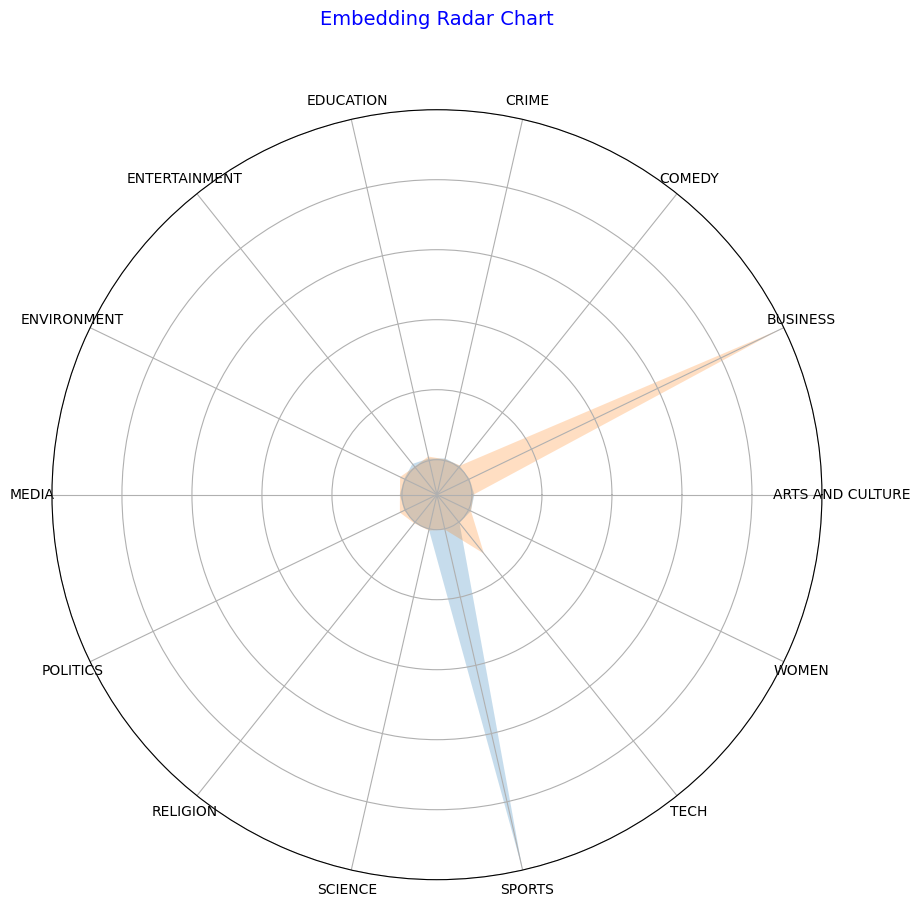

In [96]:
radar_chart(categories, [normalized_v1.tolist(), normalized_v2.tolist()], title='Embedding Radar Chart')